### BeatLM: A Beatles Song Classifier and Generator
_Yoav Rabinovich, May 2020_

-------------------------------------

Using Transfer Learning to classify Beatles songs by songwriter, inspired by ULMFiT and using the fastai library. Data-set of Beatles lyrics from GitHub user [EugenHotaj](https://github.com/EugenHotaj).

An RNN language model pre-trained on WikiText-103 is fine-tuned on the dataset, and then used as an encoder for text classification of songwriters from lyrics. The model doesn't achieve high accuracy, probably due to the over-represented class of songs credited to the Lennon & McCartney partnership, but despite its prevalence, the model does correctly classify some solo work to Harrison and Lennon. The language model intermediary step also serves as a nifty beatles song generator!

In [0]:
from fastai.text import *

In [2]:
url = "https://raw.githubusercontent.com/EugenHotaj/beatles/master/dataset.txt"
df = pd.read_csv(url, header=None, sep='\t')
df.columns = ["title","writer","lyrics"]
df.head()

,title,writer,lyrics
0,(Just Like) Starting Over,Lennon,"Our life together is so precious together,\We ..."
1,A Day In The Life,NaN,I read the news today oh boy\About a lucky man...
2,A Hard Day's Night,Lennon & McCartney,It's been a hard day's night\And I've been wor...
3,A Taste of Honey,Scott/Marlow,A taste of honey... tasting much sweeter than ...
4,A world without love,Lennon & McCartney,(as recorded by peter & gordon)\Please lock me...


In [3]:
data_lm = (TextList.from_df(df,"/content",cols="lyrics")
            .split_by_rand_pct(0.1)
            .label_for_lm()
            .databunch(bs=48))
data_lm.save('data_lm.pkl')

In [4]:
data_lm.show_batch()

idx,text
0,"xxunk , \ xxmaj but when i see you darling , \ xxmaj it 's like we both are falling in love again , \ xxmaj it 'll be just like starting over - starting over , \ xxmaj everyday we used to make it love , \ xxmaj why ca n't we be making love nice and easy , \ xxmaj it 's time to spread our wing 's"
1,across the universe . \ xxmaj jai xxmaj guru xxmaj de va xxmaj om \ xxmaj nothing 's gon na change my world \ xxmaj nothing 's gon na change my world \ xxmaj nothing 's gon na change my world \ xxmaj nothing 's gon na change my world \ xxmaj jai xxmaj guru xxmaj de va xxmaj om ... xxbos xxmaj they 're gon na put me in
2,you can save that ca n't be xxunk \ xxmaj nothing you can do but you can learn how to be you in time \ xxmaj it 's easy \ xxmaj all you need is love \ xxmaj all you need is love \ xxmaj all you need is love \ xxmaj love xxmaj that is all you need \ xxmaj there 's nothing you can know that is n't
3,"of human \ power \ xxmaj what a xxunk of human lives , \ shoot the prisioners in \ the xxunk \ xxmaj xxunk - three poor xxunk \ xxunk \ xxmaj xxunk xxunk it on the \ prisioners , \ xxmaj but the prisioners did not xxunk pulled the xxunk "" \ xxmaj that ’s what the people feel . \ xxmaj attica , xxmaj attica state , we"
4,"as recorded by cream ) \ xxmaj thinking 'bout the times you drove in my car , \ xxmaj thinking that i might have drove it too far . \ xxmaj and i ’m thinking 'bout the love that you laid on my table . \ i told you not to xxunk ' round in the dark , \ i told you 'bout the xxunk that they live in the"


In [5]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


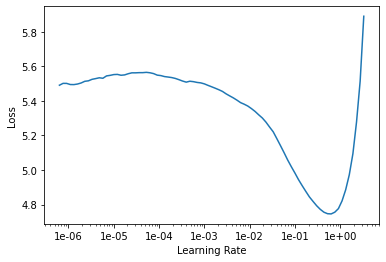

In [52]:
learn.lr_find()
learn.recorder.plot()

In [6]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
learn.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,4.004592,3.392741,0.316468,00:02


In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned')

epoch,train_loss,valid_loss,accuracy,time
0,2.012415,3.139467,0.365079,00:02


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
def write_songs(TEXT="",N_WORDS=100,N_SONGS=1,TEMPS=[0.9]):
    for i in range(N_SONGS):
        song = learn.predict(TEXT, N_WORDS, temperature=TEMPS[i%N_SONGS])
        print(song.replace("\\","\n").replace("xxbos","\n"))
        print("\n")

In [20]:
learn.load("fine_tuned")
write_songs("Happy birthday Barbara", 100, 3, [0.7,0.9,1.1])

Happy birthday Barbara love , 
 i 'm coming home to make it easy 
 And i got to say i 'll be mine 
 It 's a joy to make . 
 It 's sweet and funny , 
 It 's beautiful and we 'll be happy . 
 i 've got a feeling that 's something to be true 
 But i 'm so glad i 'll make it more and more , 
 And i will have a happy new year 
 Will you and i really make a wish 
 And


Happy birthday Barbara , oh yes you 'll be glad , 
 i hope you 'll be good after you and i will be happy . 
 We wo n't stay in a world without love . 
 We may be afraid to dance with you 
 We 'll be free if we know we 're shore we are away 
 We are in love with We World We Live In World Love 
 We know we 'll live on and we can live without 
 They 'll be through


Happy birthday Barbara , i 'm coming on 
 Oh happy the good ones 
 Happy morning coming out for ease . 
 He got my way , kids , and maybe my little lover , Things go bad 
 Misery did n't worry 
 Ah , yes , we make easy trouble , 
 You leave me standing alone 
 i 'm s

In [0]:
clean_df = df.dropna()

In [22]:
data_clas = (TextList.from_df(clean_df,"/content",vocab=data_lm.vocab,cols=["lyrics","title"])
            .split_by_rand_pct(0.1)
            .label_from_df(cols="writer")
            .databunch(bs=48))
data_clas.save('data_clas.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Dubin/Warren
  if getattr(ds, 'warn', False): warn(ds.warn)


In [23]:
data_clas.show_batch()

text,target
xxbos xxmaj well \ xxmaj be - xxmaj bop - a - xxmaj lula xxmaj she 's xxmaj my xxmaj baby \ xxmaj be - xxmaj bop - a - xxmaj lula xxmaj do n't xxmaj mean xxmaj maybe \ xxmaj be - xxmaj bop - a - xxmaj lula xxmaj she 's xxmaj my xxmaj baby \ xxmaj be - xxmaj bop - a - xxmaj lula xxmaj do,Gene Vincent/Sheriff Tex Davis
xxbos xxmaj you 're going to lose that girl \ ( xxmaj yes yes xxmaj you 're going to lose that girl ) \ xxmaj you 're going to lose that girl \ ( xxmaj yes yes xxmaj you 're going to lose that girl ) \ xxmaj if you do n't take her out tonight she 's going to change her mind \ ( xxmaj she 's going to,Lennon & McCartney
"xxbos xxmaj just let me hear some of that xxmaj rock xxmaj and xxmaj roll xxmaj music , \ xxmaj any old way you choose it ; \ xxmaj it 's got a back beat , you ca n't lose it , \ xxmaj any old time you use it . \ xxmaj it 's got ta be rock roll music , \ xxmaj if you wanna dance with me",Chuck Berry
xxbos i tried to find out \ xxmaj what love is all about \ xxmaj and every day \ xxmaj it sure lets out \ i see my baby \ i get week in my knees \ xxmaj there 's nothing shaking \ xxmaj but the leaves on the trees \ xxmaj my xxunk told me \ xxmaj there 'd be times like these \ xxmaj there 's nothing shaking,Fontaine/Calacrai/Lampert/Gluck
xxbos xxmaj desmond had a xxunk in the market place \ xxmaj molly is the singer in a band \ xxmaj desmond says to xxmaj molly girl i like your face \ xxmaj and xxmaj molly says this as she takes him by the hand \ xxmaj ob - la - di xxmaj ob - la - da life goes on \ bra - la - la how the life,Lennon & McCartney


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


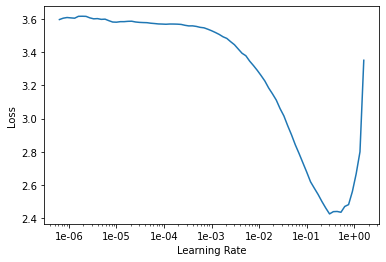

In [119]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))
learn.save('first')

epoch,train_loss,valid_loss,accuracy,time
0,3.496198,2.965366,0.444444,00:01


In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,2.652060,2.706334,0.703704,00:01


In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save('third')

epoch,train_loss,valid_loss,accuracy,time
0,2.171183,2.649914,0.629630,00:02


In [28]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

learn.save('final')

epoch,train_loss,valid_loss,accuracy,time
0,1.785372,2.710893,0.518519,00:02
1,1.725005,2.720846,0.444444,00:02


In [0]:
learn.load('final');

In [56]:
ci = TextClassificationInterpretation.from_learner(learn)

In [66]:
print("All Things Must Pass" in df["title"])
print("Live And Let Die" in df["title"])
print("Imagine" in df["title"])

False
False
False


In [67]:
prompt1 = "Sunrise doesn't last all morning. \ A cloudburst doesn't last all day \ Seems my love is up and has left you with no warning \ It's not always going to be this grey \ All things must pass \ All things must pass away"
prompt2 = "When you were young and your heart was an open book \ You used to say live and let live \ (You know you did, you know you did, you know you did) \ But if this ever changing world in which we're living \ Makes you give in and cry \ Say live and let die \ (Live and let die) \ Live and let die \ (Live and let die)"
prompt3 = "Imagine there's no heaven \ It's easy if you try\ No hell below us \ Above us only sky \ Imagine all the people living for today \ Imagine there's no countries \ It isn't hard to do \ Nothing to kill or die for \ And no religion too \ Imagine all the people living life in peace, you \ You may say I'm a dreamer \ But I'm not the only one \ I hope some day you'll join us \ And the world will be as one"
print(data_clas.classes[learn.predict(prompt1)[1]])
print(data_clas.classes[learn.predict(prompt2)[1]])
print(data_clas.classes[learn.predict(prompt3)[1]])

Harrison
Lennon
Lennon


In [69]:
ci.show_intrinsic_attention(prompt1)
ci.show_intrinsic_attention(prompt2)
ci.show_intrinsic_attention(prompt3)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


/usr/local/lib/python3.6/dist-packages/fastai/train.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


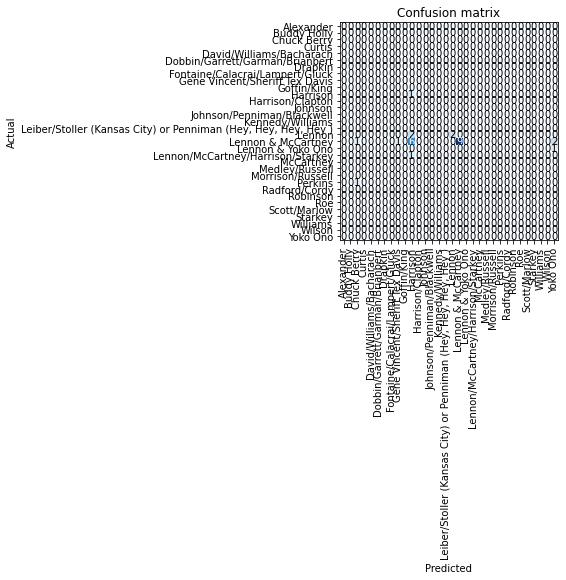

In [54]:
ci.plot_confusion_matrix()

In [58]:
ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj little child - xxmaj little child \ xxmaj little child wo n't you dance with me \ i 'm so sad and lonely \ xxmaj baby take a chance with me \ xxmaj little child - xxmaj little child \ xxmaj little child wo n't you dance with me \ i 'm so sad and lonely \ xxmaj baby take a chance with me \ xxmaj if you,Chuck Berry,Lennon & McCartney,4.28,0.01
"xxbos xxmaj people say i 'm crazy doing what i 'm doing , \ xxmaj well they give me all kinds of xxunk to save me from xxunk , \ xxmaj when i say that i 'm xxunk . they look at me kind of strange , \ xxmaj xxunk your not happy now you no longer play the game , \ xxmaj people say i 'm lazy dreaming my",Harrison,Lennon,4.08,0.02
"xxbos xxmaj love , xxwrep 5 love , \ love , love , love \ xxmaj there 's nothing you can do that ca n't be done \ xxmaj nothing you can sing that ca n't be xxunk \ xxmaj nothing you can say but you learn how to play the game . \ xxmaj it 's easy \ xxmaj all you need is love \ xxmaj all you need",Harrison,Lennon & McCartney,3.88,0.02
"xxbos xxmaj ah , xxmaj look at all the lonely people . \ xxmaj xxunk xxmaj xxunk picks up the xxunk in the church \ xxmaj where a xxunk has been xxmaj lives in a dream \ xxmaj waits at the window , wearing the face that she keeps in a jar by the door . xxmaj who is it for ? \ xxmaj all the lonely people , where",Harrison,Lennon & McCartney,3.74,0.02
"xxbos xxmaj free xxmaj as a xxmaj bird , \ xxmaj it 's the next best thing to be free as a bird . \ xxmaj home , home and xxunk \ xxmaj like a xxunk bird i fly , as a bird on wings \ xxmaj whatever happened to the life that we once knew \ xxmaj can we really live without each other \ xxmaj where did we",Harrison,Lennon/McCartney/Harrison/Starkey,3.58,0.03
"xxbos xxmaj well how can you say you will when you wo n't , \ xxmaj say you do , baby , when you do n't ? \ xxmaj tell the truth now , is love real ? \ xxmaj but oh well honey do n't , well honey do n't , \ xxmaj honey do n't , honey do n't , honey do n't \ i say you will",Chuck Berry,Perkins,3.35,0.03
"xxbos xxmaj angela , they put you in \ xxunk \ xxmaj angela , they shot down \ your man \ xxmaj angela , xxunk one of the \ xxunk of xxunk \ prisioners in the world . \ xxmaj sister , xxunk wind that \n ever xxunk \ xxmaj sister , xxunk breathing \ together \ xxmaj sister , our loves and xxunk \ forever keep \ on",Yoko Ono,Lennon & Yoko Ono,3.30,0.04
"xxbos xxmaj it feels so right now \ xxmaj hold me tight \ xxmaj tell me i 'm the only one \ xxmaj and then i might \ xxmaj never be the lonely one . \ xxmaj so hold me tight tonight , tonight it 's you \ xxmaj you , you , you - oo - oo - oo oo \ xxmaj hold me tight \ xxmaj let me",Gene Vincent/Sheriff Tex Davis,Lennon & McCartney,3.25,0.04
"xxbos ( as recorded by the xxunk with xxunk xxunk ) \ xxmaj one and one is two , \ xxmaj what am i to do \ xxmaj now that i ’m in love with you ? \ i ’m hoping ev´ry day , \ i ’m gon na hear you say , \ xxmaj you really make my wish come true . \ xxmaj ca n't you feel when",Yoko Ono,Lennon & McCartney,3.21,0.04
"xxbos xxmaj good xxmaj day xxmaj sunshine , xxmaj good xxmaj day xxmaj sunshine , xxmaj good xxmaj day xxmaj sunshine , \ i need to laugh , and when the sun is out \ i 've got something i can xxunk about i feel good \ xxmaj in a special way , i 'm in love and it 's a sunny day . \ xxmaj good xxmaj day xxmaj",Yoko Ono,Lennon & McCartney,3.12,0.04
